# 📦 Create Patches Dataset

**Objective:** Extract 128×128×14 patches from 4 TIFF files at ground truth locations

**Input:**
- 4 TIFF files (S1 2024/2025, S2 2024/2025)
- Ground truth CSV with 1,285 points

**Output:**
- Train patches: ~900 files (.npy)
- Val patches: ~190 files
- Test patches: ~195 files

**Processing:**
1. Load 4 TIFF files
2. Stack into 14-channel array
3. Extract patches at ground truth coordinates
4. Handle NaN values
5. Normalize bands
6. Split train/val/test
7. Save as .npy files

**Expected time:** 10-15 minutes

## 1. Setup Python Path and Import Libraries

In [1]:
import sys
from pathlib import Path

# Add project root and src to Python path
project_root = Path.cwd().parent
src_path = project_root / 'src'

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

print("✅ Python path configured:")
print(f"   Project root: {project_root}")
print(f"   Source dir: {src_path}")

# Now import libraries
import numpy as np
import matplotlib.pyplot as plt
import time

# Import from src
from src.preprocessing import create_patches_dataset
from src.utils import load_ground_truth

print("\n✅ Libraries imported successfully!")

✅ Python path configured:
   Project root: d:\HaiDang\25-26_HKI_DATN_21021411_DangNH
   Source dir: d:\HaiDang\25-26_HKI_DATN_21021411_DangNH\src

✅ Libraries imported successfully!


## 2. Check Data Availability

In [2]:
base_dir = Path('../data/raw')

files = {
    'S1_2024': base_dir / 'sentinel1' / 'S1_2024_02_04_matched_S2_2024_01_30.tif',
    'S1_2025': base_dir / 'sentinel1' / 'S1_2025_02_22_matched_S2_2025_02_28.tif',
    'S2_2024': base_dir / 'sentinel2' / 'S2_2024_01_30.tif',
    'S2_2025': base_dir / 'sentinel2' / 'S2_2025_02_28.tif',
    'GT_CSV': base_dir / 'ground_truth' / 'Training_Points_CSV.csv'
}

print("📊 Checking data availability...\n")
all_exist = True
for name, filepath in files.items():
    exists = filepath.exists()
    status = "✅" if exists else "❌"
    size = f"{filepath.stat().st_size / (1024**2):.0f} MB" if exists else "N/A"
    print(f"{status} {name:10s}: {size:>8s}")
    all_exist = all_exist and exists

if all_exist:
    print("\n✅ All files available! Ready to create patches.")
else:
    print("\n❌ Some files missing! Please check data directory.")
    raise FileNotFoundError("Required data files not found")

📊 Checking data availability...

✅ S1_2024   :   523 MB
✅ S1_2025   :   523 MB
✅ S2_2024   :  3658 MB
✅ S2_2025   :  3658 MB
✅ GT_CSV    :     0 MB

✅ All files available! Ready to create patches.


## 3. Check Ground Truth Summary

In [3]:
gt_df = load_ground_truth(files['GT_CSV'])

print(f"📊 Ground Truth Summary:")
print(f"  Total points: {len(gt_df)}")
print(f"\n  Class distribution:")
for label in [0, 1]:
    count = (gt_df['label'] == label).sum()
    pct = 100 * count / len(gt_df)
    label_name = "No deforestation" if label == 0 else "Deforestation"
    print(f"    Class {label} ({label_name}): {count} ({pct:.1f}%)")

print(f"\n  Expected split (70/15/15):")
print(f"    Train: ~{int(len(gt_df) * 0.70)} patches")
print(f"    Val:   ~{int(len(gt_df) * 0.15)} patches")
print(f"    Test:  ~{int(len(gt_df) * 0.15)} patches")

📊 Ground Truth Summary:
  Total points: 1285

  Class distribution:
    Class 0 (No deforestation): 650 (50.6%)
    Class 1 (Deforestation): 635 (49.4%)

  Expected split (70/15/15):
    Train: ~899 patches
    Val:   ~192 patches
    Test:  ~192 patches


## 4. Create Patches Dataset

**⚠️ WARNING:** This will take 10-15 minutes. The function will:
1. Load ~4GB of TIFF files into memory
2. Extract 1,285 patches (128×128×14 each)
3. Process NaN values
4. Normalize 14 channels
5. Save ~1,285 .npy files

**Progress bars (tqdm) will show real-time progress.**

In [4]:
print("🚀 Starting dataset creation...\n")
print("⏱️ This will take approximately 10-15 minutes.")
print("☕ Time for coffee!\n")
print("="*80)

start_time = time.time()

try:
    counts = create_patches_dataset(
        s1_2024_path=files['S1_2024'],
        s1_2025_path=files['S1_2025'],
        s2_2024_path=files['S2_2024'],
        s2_2025_path=files['S2_2025'],
        ground_truth_csv=files['GT_CSV'],
        output_dir='../data/patches',
        patch_size=128,
        train_ratio=0.70,
        val_ratio=0.15,
        test_ratio=0.15,
        normalize=True,
        handle_nan_method='fill',
        random_seed=42
    )
    
    elapsed_time = time.time() - start_time
    
    print("\n" + "="*80)
    print("✅ DATASET CREATION COMPLETED!")
    print("="*80)
    print(f"\n⏱️ Time elapsed: {elapsed_time/60:.1f} minutes")
    print(f"\n📊 Patches created:")
    print(f"  Train: {counts['train']} patches")
    print(f"  Val:   {counts['val']} patches")
    print(f"  Test:  {counts['test']} patches")
    print(f"  Total: {sum(counts.values())} patches")
    
except Exception as e:
    print(f"\n❌ Error occurred: {e}")
    import traceback
    traceback.print_exc()

🚀 Starting dataset creation...

⏱️ This will take approximately 10-15 minutes.
☕ Time for coffee!

Loading ground truth...
Loaded 1285 ground truth points
Splitting dataset: 0.7/0.15/0.15...
Train: 899, Val: 193, Test: 193

Loading TIFF files...
  - Sentinel-2 2024...
  - Sentinel-2 2025...

Stacking 14 bands (Sentinel-2 only)...
Stacked shape: (14, 10917, 12547)
Transposed shape: (10917, 12547, 14)

Processing TRAIN set (899 samples)...


TRAIN:   0%|          | 0/899 [00:00<?, ?patch/s]

✅ TRAIN: Saved 899/899 patches

Processing VAL set (193 samples)...


VAL:   0%|          | 0/193 [00:00<?, ?patch/s]

✅ VAL: Saved 193/193 patches

Processing TEST set (193 samples)...


TEST:   0%|          | 0/193 [00:00<?, ?patch/s]

✅ TEST: Saved 193/193 patches

✅ Summary saved to: ..\data\patches\dataset_summary.txt

DATASET CREATION COMPLETED

✅ DATASET CREATION COMPLETED!

⏱️ Time elapsed: 0.7 minutes

📊 Patches created:
  Train: 899 patches
  Val:   193 patches
  Test:  193 patches
  Total: 1285 patches


## 5. Verify Patches Directory

In [5]:
patches_dir = Path('../data/patches')

print("📁 Checking patches directory...\n")

for split in ['train', 'val', 'test']:
    split_dir = patches_dir / split
    if split_dir.exists():
        files = list(split_dir.glob('*.npy'))
        total_size = sum(f.stat().st_size for f in files) / (1024**2)
        print(f"✅ {split.upper()}:")
        print(f"   Files: {len(files)}")
        print(f"   Size: {total_size:.1f} MB")
        print(f"   Example: {files[0].name if files else 'N/A'}\n")
    else:
        print(f"❌ {split.upper()}: Directory not found\n")

# Check summary file
summary_file = patches_dir / 'dataset_summary.txt'
if summary_file.exists():
    print(f"✅ Summary file: {summary_file.name}")
    print("\nContent:")
    print(summary_file.read_text())
else:
    print(f"❌ Summary file not found")

📁 Checking patches directory...

✅ TRAIN:
   Files: 899
   Size: 786.7 MB
   Example: train_0352_label1.npy

✅ VAL:
   Files: 193
   Size: 168.9 MB
   Example: val_0357_label1.npy

✅ TEST:
   Files: 193
   Size: 168.9 MB
   Example: test_0351_label1.npy

✅ Summary file: dataset_summary.txt

Content:
PATCHES DATASET SUMMARY

Patch size: 128×128
Channels: 18
Normalized: True
NaN handling: fill

Train: 899
Val: 193
Test: 193
Total: 1285



## 6. Load and Visualize Sample Patches

📊 Loading sample patches...

✅ Loaded patches:
   Class 0: train_1349_label0.npy
   Shape: (128, 128, 14)
   Dtype: float32
   Range: [-3.794, 16.182]

   Class 1: train_0352_label1.npy
   Shape: (128, 128, 14)
   Dtype: float32
   Range: [-15.675, 19.490]

📊 Visualizing key bands...


IndexError: index 3 is out of bounds for axis 1 with size 3

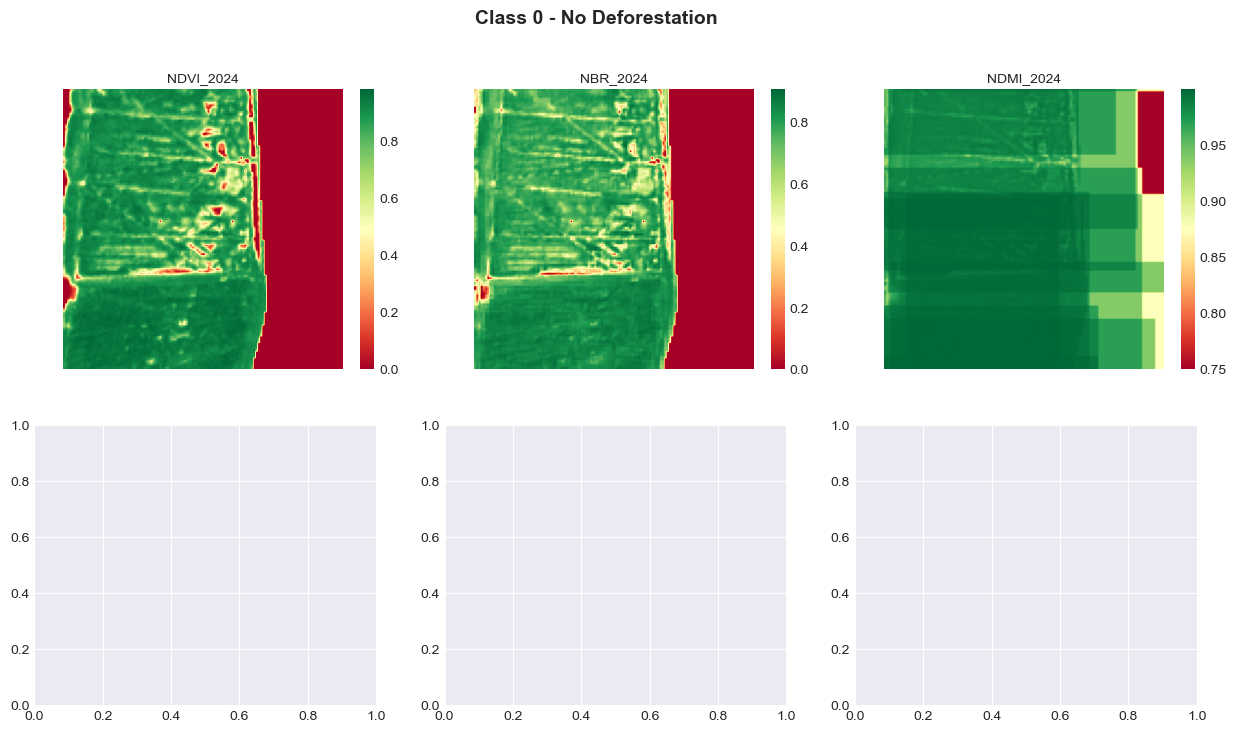

In [6]:
print("📊 Loading sample patches...\n")

# Load one patch from each class
train_dir = patches_dir / 'train'

# Find patches for each class
class_0_files = sorted(list(train_dir.glob('*_label0.npy')))
class_1_files = sorted(list(train_dir.glob('*_label1.npy')))

if class_0_files and class_1_files:
    # Load patches
    patch_0 = np.load(class_0_files[0])
    patch_1 = np.load(class_1_files[0])
    
    print(f"✅ Loaded patches:")
    print(f"   Class 0: {class_0_files[0].name}")
    print(f"   Shape: {patch_0.shape}")
    print(f"   Dtype: {patch_0.dtype}")
    print(f"   Range: [{patch_0.min():.3f}, {patch_0.max():.3f}]")
    print()
    print(f"   Class 1: {class_1_files[0].name}")
    print(f"   Shape: {patch_1.shape}")
    print(f"   Dtype: {patch_1.dtype}")
    print(f"   Range: [{patch_1.min():.3f}, {patch_1.max():.3f}]")
    
    # Visualize key bands
    print("\n📊 Visualizing key bands...")
    
    band_indices = [4, 5, 6, 11, 12, 13]  # S2 indices only (NDVI, NBR, NDMI for 2024 and 2025)
    band_names = ['NDVI_2024', 'NBR_2024', 'NDMI_2024',
              'NDVI_2025', 'NBR_2025', 'NDMI_2025']
    
    # Plot Class 0
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle('Class 0 - No Deforestation', fontsize=14, fontweight='bold')
    
    for idx, (band_idx, band_name) in enumerate(zip(band_indices, band_names)):
        ax = axes[idx // 3, idx % 3]
        im = ax.imshow(patch_0[:, :, band_idx], cmap='RdYlGn')
        ax.set_title(band_name, fontsize=10)
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046)
    
    plt.tight_layout()
    plt.show()
    
    # Plot Class 1
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle('Class 1 - Deforestation', fontsize=14, fontweight='bold')
    
    for idx, (band_idx, band_name) in enumerate(zip(band_indices, band_names)):
        ax = axes[idx // 3, idx % 3]
        im = ax.imshow(patch_1[:, :, band_idx], cmap='RdYlGn')
        ax.set_title(band_name, fontsize=10)
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Could not find sample patches for both classes")

## 7. Check for NaN Values in Patches

In [ ]:
print("🔍 Checking for NaN values in sample patches...\n")

# Check 10 random patches
import random

all_files = list(train_dir.glob('*.npy'))
sample_files = random.sample(all_files, min(10, len(all_files)))

nan_counts = []
for f in sample_files:
    patch = np.load(f)
    nan_count = np.isnan(patch).sum()
    nan_counts.append(nan_count)
    if nan_count > 0:
        print(f"⚠️ {f.name}: {nan_count} NaN values")

if sum(nan_counts) == 0:
    print("✅ No NaN values found in sampled patches!")
    print("   NaN handling was successful.")
else:
    print(f"\n⚠️ Found {sum(nan_counts)} NaN values across {sum(c > 0 for c in nan_counts)} patches")
    print("   You may need to adjust NaN handling method.")

## 8. Summary & Next Steps

In [ ]:
print("\n" + "="*80)
print("📊 DATASET CREATION SUMMARY")
print("="*80)

print("\n✅ Completed Tasks:")
print("  1. Loaded 4 TIFF files (~4GB)")
print("  2. Stacked into 14-channel array")
print("  3. Extracted patches at ground truth locations")
print("  4. Handled NaN values")
print("  5. Normalized all bands")
print("  6. Split into train/val/test sets")
print(f"  7. Saved {sum(counts.values())} .npy files")

print("\n📁 Output Directory:")
print(f"  {patches_dir.resolve()}")

print("\n📦 Patch Specifications:")
print(f"  Size: 128 × 128 pixels")
print(f"  Channels: 14 (7 S2 bands × 2 time points)")
print(f"  Data type: float32")
print(f"  Normalization: Mixed (S2 reflectance: clip, S2 indices: scaled)")
print(f"  NaN handling: fill with 0")

print("\n🚀 Next Steps:")
print("  1. ✅ Patches created and verified")
print("  2. ⬜ Train models (notebook 03_train_models.ipynb)")
print("  3. ⬜ Evaluate results (notebook 04_evaluate_and_visualize_results.ipynb)")

print("\n" + "="*80)